In [1]:
#Testing models

In [1]:
# -*- coding: UTF-8 -*-
# Local modules
import os
import sys
import argparse
# 3rd-Party Modules
import numpy as np
import pickle as pk
import pandas as pd
from tqdm import tqdm
import glob
import librosa
import copy

# PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import ConcatDataset, DataLoader
import torch.optim as optim
from transformers import AutoModel
import importlib
# Self-Written Modules
sys.path.append(os.getcwd())
sys.path.append('../')
from benchmark import net
from benchmark import utils

In [2]:
# !pip install --upgrade transformers

In [3]:
import transformers
transformers.__version__

'4.47.1'

In [48]:
ssl_model = AutoModel.from_pretrained('microsoft/wavlm-base')
# ssl_model = AutoModel.from_pretrained('microsoft/wavlm-base-plus-sv')
ssl_model.freeze_feature_encoder()
ssl_model.eval();

In [5]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
text_model = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [68]:
!ls ../test/whisper_transcripts.csv

../test/whisper_transcripts.csv


In [70]:
texts = pd.read_csv('../test/whisper_transcripts.csv')
texts['l'] = texts['transcription'].str.len()

In [72]:
texts.head(2)

,FileName,transcription,l
0,MSP-PODCAST_0002_0033.wav,"and I mean the numbers, right? So...",37
1,MSP-PODCAST_0002_0039.wav,1500 or something. It talks about the two dif...,208


In [76]:
texts.sort_values(by='l', ascending=False).head(2).transcription.values[0]

' blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah blah bla

In [77]:
texts.sort_values(by='l', ascending=False).head(2).transcription.values[1]

' Stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch, stretch,

In [79]:
texts.sort_values(by='l', ascending=False).head(5).transcription.values[2]

' I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no idea what was going on. I had no

In [85]:
import IPython
IPython.display.Audio('../data/Audios/MSP-PODCAST_5205_0625.wav')

In [86]:
import IPython
IPython.display.Audio('../data/Audios/MSP-PODCAST_3874_0531.wav')

In [104]:
import IPython
IPython.display.Audio('../data/Audios/MSP-PODCAST_0835_0374_0004.wav')

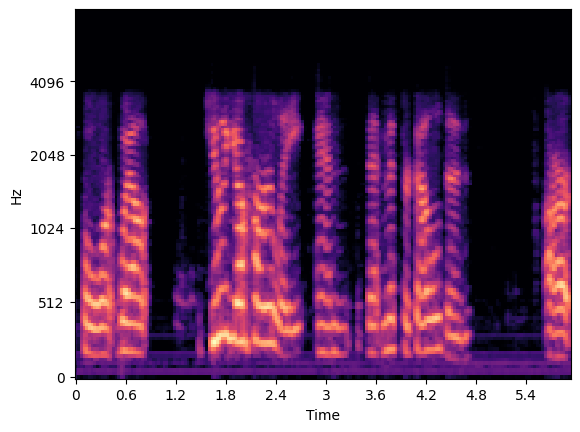

In [105]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

y, sr = librosa.load('../data/Audios/MSP-PODCAST_0835_0374_0004.wav', sr = None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)

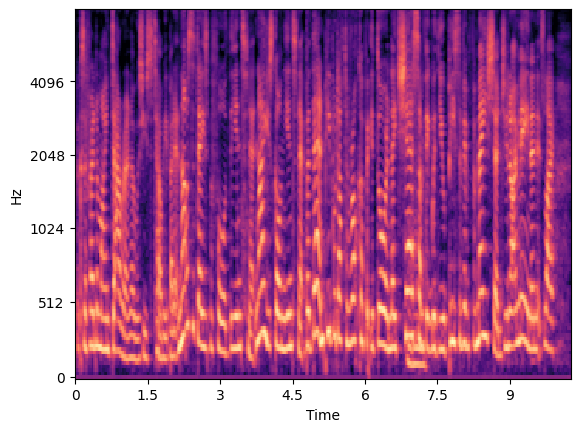

In [109]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

y, sr = librosa.load('../data/Audios/MSP-PODCAST_4279_0098_0000.wav', sr = None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                    fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)

In [107]:
texts[texts.l > 500].sort_values(by='l', ascending=False).head(2)

,FileName,transcription,l
103588,MSP-PODCAST_5205_0625.wav,blah blah blah blah blah blah blah blah blah ...,2220
90423,MSP-PODCAST_3874_0531.wav,"Stretch, stretch, stretch, stretch, stretch, ...",1998


In [100]:
texts[texts.l < 500].sort_values(by='l', ascending=False).head(10)

,FileName,transcription,l
20809,MSP-PODCAST_0835_0374_0004.wav,FOR THEIR FAMILY. FOR THEIR FAMILY. AND FOR T...,390
87720,MSP-PODCAST_3659_0023_0000.wav,But I still want to fly. You know what I mean...,335
94925,MSP-PODCAST_4259_0041.wav,"is all we burn. But listen, man, this million...",304
95674,MSP-PODCAST_4279_0098_0000.wav,"because a friend of mine, Darren, always used...",297
13593,MSP-PODCAST_0529_0122.wav,war on drugs and the way that Hollywood more ...,288
98552,MSP-PODCAST_4689_0016_0002.wav,"Dude, why does this happen? Like, why do peop...",288
21058,MSP-PODCAST_0845_0201.wav,And then we started getting bits and pieces i...,285
97701,MSP-PODCAST_4594_0149_0000.wav,I'm not saying this to you. I'm saying this t...,285
3492,MSP-PODCAST_0110_0318.wav,A lot of them are walking down the street. Th...,282
97532,MSP-PODCAST_4573_0036_0002.wav,And I went to go check if that was the room I...,281


In [125]:
texts[texts.l < 5].sort_values(by='l', ascending=True).head(10)

,FileName,transcription,l
3338,MSP-PODCAST_0108_0404.wav,.,2
84747,MSP-PODCAST_3198_0004_0002.wav,I,2
115477,MSP-PODCAST_5878_0115_0003.wav,um,3
11591,MSP-PODCAST_0384_0325.wav,uh,3
107922,MSP-PODCAST_5500_0176_0001.wav,R.,3
114549,MSP-PODCAST_5767_0232.wav,But,4
113181,MSP-PODCAST_5723_0605_0000.wav,"So,",4
111817,MSP-PODCAST_5675_0798.wav,"So,",4
104385,MSP-PODCAST_5268_0176.wav,And,4
85550,MSP-PODCAST_3232_0045.wav,"So,",4


In [127]:
import IPython
IPython.display.Audio('../data/Audios/MSP-PODCAST_3198_0004_0002.wav')

In [131]:
!ls ../benchmark/processed_labels.csv

../benchmark/processed_labels.csv


In [132]:
real_df = pd.read_csv('../benchmark/processed_labels.csv')

In [149]:
filtered_df = texts[texts.FileName.isin(real_df['FileName'])]
filtered_df = filtered_df.merge(real_df[['FileName','Split_Set']], on ='FileName', how='left')

In [150]:
filtered_df.shape

(92250, 4)

In [151]:
filtered_df[(filtered_df.l < 5)&(filtered_df.Split_Set == 'Development')].sort_values(by='l', ascending=True).head(10)

,FileName,transcription,l,Split_Set
66047,MSP-PODCAST_3198_0004_0002.wav,I,2,Development
40615,MSP-PODCAST_2336_1461.wav,No.,4,Development
42164,MSP-PODCAST_2347_2401.wav,...,4,Development
66670,MSP-PODCAST_3232_0045.wav,"So,",4,Development
82062,MSP-PODCAST_5268_0176.wav,And,4,Development


In [167]:
filtered_df[(filtered_df.l > 300)&(filtered_df.Split_Set == 'Development')].sort_values(by='l', ascending=False).head(10)

,FileName,transcription,l,Split_Set
81383,MSP-PODCAST_5205_0625.wav,blah blah blah blah blah blah blah blah blah ...,2220,Development
35910,MSP-PODCAST_2105_2388.wav,"And, you know, he said if he did that, it wou...",1421,Development
49633,MSP-PODCAST_2421_1572.wav,Ba ba ba ba ba ba ba ba ba ba ba ba ba ba ba ...,1332,Development
65920,MSP-PODCAST_3187_0781.wav,"ymgyrchion, ymgyrchion, ymgyrchion, ymgyrchio...",761,Development
66023,MSP-PODCAST_3196_0753.wav,"Ie, i'w ddweud y gwir. Ie, i'w ddweud y gwir....",722,Development
68414,MSP-PODCAST_3659_0023_0000.wav,But I still want to fly. You know what I mean...,335,Development


In [174]:
import IPython
ref = "MSP-PODCAST_3659_0023_0000.wav"
IPython.display.Audio('../data/Audios/' + ref)

In [175]:
real_df[real_df['FileName']== ref]

,FileName,Angry,Sad,Happy,Surprise,Fear,Disgust,Contempt,Neutral,Split_Set
68414,MSP-PODCAST_3659_0023_0000.wav,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Development


In [110]:
texts[texts.l < 500].sort_values(by='l', ascending=False).head(10).transcription.values[3]

" because a friend of mine, Darren, always used to tell me about it. And that was the days before the internet. Now you just go on the internet, but then people would have to rock up at your door and they'd share something with you, a piece of information. Do you know what I mean? And it's like..."

In [99]:
texts.l.mean(), texts[texts.l > 500].shape

(85.90476764095989, (46, 3))

In [33]:
text_model.config.hidden_size

768

In [114]:
text = " because a friend of mine, Darren, always used to tell me about it. And that was the days before the internet. Now you just go on the internet, but then people would have to rock up at your door and they'd share something with you, a piece of information. Do you know what I mean? And it's like..."
# inputs = tokenizer(text, return_tensors="pt", padding="max_length", max_length=20,truncation=True).to(device)
inputs = tokenizer(text, return_tensors="pt", padding=True,truncation=True).to(device)

In [115]:
with torch.no_grad():  # Disable gradient computation for inference
    outputs = text_model(**inputs)

In [116]:
outputs.last_hidden_state.shape

torch.Size([1, 71, 768])

In [37]:
!ls ../data/Audios/ | head -n 10 

MSP-PODCAST_0002_0033.wav
MSP-PODCAST_0002_0039.wav
MSP-PODCAST_0002_0051.wav
MSP-PODCAST_0002_0059.wav
MSP-PODCAST_0002_0061.wav
MSP-PODCAST_0002_0124.wav
MSP-PODCAST_0003_0052.wav
MSP-PODCAST_0003_0084.wav
MSP-PODCAST_0003_0085.wav
MSP-PODCAST_0003_0086.wav
ls: write error: Broken pipe


In [49]:
y, sr = librosa.load('../data/Audios/MSP-PODCAST_0002_0033.wav', sr = None)

In [50]:
y = torch.FloatTensor(y).unsqueeze(0)

In [51]:
out_wav = ssl_model(y)

In [52]:
out_wav.last_hidden_state.shape

torch.Size([1, 141, 768])

In [53]:
out_wav.last_hidden_state[0][0][:10]

tensor([-0.1480,  0.1707, -0.2093,  0.3699,  0.1181,  0.5440, -0.2681, -0.0476,
        -0.1947, -0.8220], grad_fn=<SliceBackward0>)

In [47]:
out_wav.last_hidden_state[0][0][:10]

tensor([ 0.0928,  0.2589, -0.0962, -0.0822,  0.0922,  0.0650,  0.1422, -0.0599,
        -0.1463, -0.2592], grad_fn=<SliceBackward0>)

In [15]:
cur_utts, cur_labs = utils.load_cat_emo_label('/workspace/lucas.ueda/interspeech_ser/benchmark/processed_labels.csv', 'train')

In [17]:
cur_labs

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
torch.save(out_wav.last_hidden_state.squeeze(0), 'debug_feat.pt')

In [20]:
x = torch.load("debug_feat.pt")
x.shape

torch.Size([199, 768])

In [21]:
x.device

device(type='cpu')

In [19]:

import torch.nn as nn

In [22]:
kernel_size = 3
cnn1 = nn.Conv1d(
            in_channels=768,  # Input channels = hidden size of RoBERTa
            out_channels=256,
            kernel_size=kernel_size,
            padding=kernel_size // 2  # Padding to maintain sequence length
        ).to(device)

cnn2 = nn.Conv1d(
            in_channels=768,  # Input channels = hidden size of RoBERTa
            out_channels=256,
            kernel_size=kernel_size,
            padding=kernel_size // 2  # Padding to maintain sequence length
        ).to(device)

In [24]:
text_out = cnn1(outputs.last_hidden_state.permute(0,2,1).to(device))
wav_out = cnn2(out_wav.last_hidden_state.permute(0,2,1).to(device))

print(text_out.shape, wav_out.shape)

torch.Size([1, 256, 6]) torch.Size([1, 256, 199])


In [26]:
maxpool = nn.AdaptiveMaxPool1d(1)
# m_text = nn.MaxPool1d(3, stride=2)
# m_audio = m = nn.MaxPool1d(7, stride=5)

text_out2 = maxpool(text_out)
wav_out2 = maxpool(wav_out)

print(text_out2.shape, wav_out2.shape)

torch.Size([1, 256, 1]) torch.Size([1, 256, 1])


In [6]:
# ssl_model.config.hidden_size

In [7]:
# torch.cuda.empty_cache()
# del transcriber

In [8]:
from transformers import pipeline
import numpy as np

# transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3", device=0, batch_size= 64)

from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
import torch

# Load model and processor
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-large-v3").to("cuda")
processor = AutoProcessor.from_pretrained("openai/whisper-large-v3")

# Disable gradient computation
model.eval()

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0): WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
    

In [9]:

import logging

In [10]:
df = pd.read_csv('../benchmark/processed_labels.csv')
df.head(2)

,FileName,Angry,Sad,Happy,Surprise,Fear,Disgust,Contempt,Neutral,Split_Set
0,MSP-PODCAST_0002_0033.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Development
1,MSP-PODCAST_0002_0039.wav,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Development


In [11]:
!ls ../data/Labels/labels_consensus.csv

../data/Labels/labels_consensus.csv


In [12]:
df = pd.read_csv('../data/Labels/labels_consensus.csv')
df.head(2)

,FileName,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set
0,MSP-PODCAST_0002_0033.wav,N,4.8,4.2,5.4,127,Female,Development
1,MSP-PODCAST_0002_0039.wav,N,4.0,4.2,4.2,127,Female,Development


In [13]:
def transcribe(audio_files, batch_size=8):
    results = []
    for i in range(0, len(audio_files), batch_size):
        batch = audio_files[i:i + batch_size]

        # Prepare inputs
        inputs = processor(batch, sampling_rate=16000, return_tensors="pt", padding=True)

        # Move inputs to GPU
        input_features = inputs["input_features"].to("cuda")

        # Perform inference
        with torch.no_grad():
            output = model.generate(input_features)

        # Decode and store results
        transcriptions = processor.batch_decode(output, skip_special_tokens=True)
        results.extend(transcriptions)
    return results

In [14]:
# # Prepare inputs
# inputs = processor(batch, sampling_rate=16000, return_tensors="pt", padding=True)

# # Move inputs to GPU
# input_features = inputs["input_features"].to("cuda")

# # Perform inference
# with torch.no_grad():
#     output = model.generate(input_features)

# # Decode and store results
# transcriptions = processor.batch_decode(output, skip_special_tokens=True)

In [15]:
sample = f"../data/Audios/{df.FileName.values[1]}"

y, sr = librosa.load(sample)

# result = transcriber({"sampling_rate": sr, "raw": y})["text"]  

inputs = processor([y,y], sampling_rate=16000, return_tensors="pt")#,  padding=True, max_length=3000)

# inputs["input_features"].shape

# # Move inputs to GPU
input_features = inputs["input_features"].to("cuda")

# # # Perform inference
with torch.no_grad():
    output = model.generate(input_features)

# # # Decode and store results
transcriptions = processor.batch_decode(output, skip_special_tokens=True)
transcriptions

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[" 1500 or something. It talks about the two different medical devices that they're authorizing them to use. And part one of them is for them to allow these chips to go into our bodies for medical purposes.",
 " 1500 or something. It talks about the two different medical devices that they're authorizing them to use. And part one of them is for them to allow these chips to go into our bodies for medical purposes."]

In [16]:
def transcribe_it(y):
    # y, sr = librosa.load(w_path)

    # result = transcriber({"sampling_rate": sr, "raw": y})["text"]  
    
    inputs = processor(y, sampling_rate=16000, return_tensors="pt")#,  padding=True, max_length=3000)
    
    # inputs["input_features"].shape
    
    # # Move inputs to GPU
    input_features = inputs["input_features"].to("cuda")
    
    # # # Perform inference
    with torch.inference_mode():
        output = model.generate(input_features)

    del input_features 
    
    # # # Decode and store results
    transcriptions = processor.batch_decode(output, skip_special_tokens=True)
    return transcriptions

In [17]:
 y, sr = librosa.load(sample)

transcribe_it(y)

[" 1500 or something. It talks about the two different medical devices that they're authorizing them to use. And part one of them is for them to allow these chips to go into our bodies for medical purposes."]

In [18]:
wav_files = [f"../data/Audios/{f}" for f in df.FileName]
file_ids = df.FileName

In [19]:
import os

for w in wav_files:
    if(not os.path.isfile(w)):
        print('error')
        break

In [20]:
# !pip install datasets

In [ ]:
# Helper function to load audio files
def load_audio(file_path):
    audio, _ = librosa.load(file_path, sr=16000)  # Ensure 16kHz sampling rate
    return audio

batch_size = 32
import tqdm
import gc
# Process in batches
results = []
c = 0
for i in tqdm.tqdm(range(0, len(wav_files), batch_size)):
    model.past_key_values = None
    batch_files = wav_files[i:i + batch_size]
    batch_ids = file_ids[i:i + batch_size]

    # Load audio files for the current batch
    audios = [load_audio(file) for file in batch_files]

    # Get transcriptions
    transcriptions = transcribe_it(audios)

    # torch.cuda.empty_cache()
    # torch.cuda.empty_cache()
    # gc.collect()
    # torch.cuda.synchronize()
    # gc.collect()

    if(c%5==0):
        torch.cuda.empty_cache()
        gc.collect()
        # torch.cuda.reset_peak_memory_stats()
        # Optional: Force CUDA device reset
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.reset_accumulated_memory_stats()

    if(c%10==0):
        del model
        model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-large-v3").to("cuda")
        
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB // GPU memory reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    # del audios
    # transcriber.model.to("cpu")
    # torch.cuda.empty_cache()
    # transcriber.model.to("cuda")
    # Merge transcriptions with IDs
    for trans, file_id in zip(transcriptions, batch_ids):
        results.append({"FileName": file_id, "transcription": trans})

    c += 1

  0%|                                                                               | 1/3632 [00:24<24:36:52, 24.40s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  0%|                                                                               | 2/3632 [00:46<22:58:37, 22.79s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|                                                                               | 3/3632 [01:08<22:39:37, 22.48s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.83 GB


  0%|                                                                               | 4/3632 [01:31<22:48:57, 22.64s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 30.06 GB


  0%|                                                                               | 5/3632 [01:53<22:36:11, 22.44s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 30.06 GB


  0%|▏                                                                              | 6/3632 [02:15<22:33:03, 22.39s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  0%|▏                                                                              | 7/3632 [02:37<22:32:58, 22.39s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▏                                                                              | 8/3632 [03:00<22:36:56, 22.47s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  0%|▏                                                                              | 9/3632 [03:22<22:32:24, 22.40s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  0%|▏                                                                             | 10/3632 [03:45<22:34:31, 22.44s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  0%|▏                                                                             | 11/3632 [04:11<23:37:51, 23.49s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  0%|▎                                                                             | 12/3632 [04:33<23:13:17, 23.09s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▎                                                                             | 13/3632 [04:55<23:02:00, 22.91s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▎                                                                             | 14/3632 [05:17<22:47:08, 22.67s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▎                                                                             | 15/3632 [05:40<22:41:39, 22.59s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▎                                                                             | 16/3632 [06:03<22:44:30, 22.64s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  0%|▎                                                                             | 17/3632 [06:25<22:38:10, 22.54s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  0%|▍                                                                             | 18/3632 [06:48<22:42:28, 22.62s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.83 GB


  1%|▍                                                                             | 19/3632 [07:10<22:44:50, 22.67s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.83 GB


  1%|▍                                                                             | 20/3632 [07:33<22:47:12, 22.71s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.86 GB


  1%|▍                                                                             | 21/3632 [07:59<23:47:16, 23.72s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|▍                                                                             | 22/3632 [08:21<23:18:42, 23.25s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▍                                                                             | 23/3632 [08:43<22:50:34, 22.79s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▌                                                                             | 24/3632 [09:05<22:32:43, 22.50s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▌                                                                             | 25/3632 [09:27<22:31:25, 22.48s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▌                                                                             | 26/3632 [09:50<22:35:02, 22.55s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|▌                                                                             | 27/3632 [10:12<22:24:21, 22.37s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▌                                                                             | 28/3632 [10:35<22:26:47, 22.42s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▌                                                                             | 29/3632 [10:57<22:23:28, 22.37s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▋                                                                             | 30/3632 [11:20<22:42:03, 22.69s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 30.07 GB


  1%|▋                                                                             | 31/3632 [11:47<23:53:33, 23.89s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|▋                                                                             | 32/3632 [12:09<23:12:02, 23.20s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▋                                                                             | 33/3632 [12:31<22:57:11, 22.96s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▋                                                                             | 34/3632 [12:53<22:42:50, 22.73s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▊                                                                             | 35/3632 [13:15<22:33:24, 22.58s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▊                                                                             | 36/3632 [14:03<29:59:30, 30.03s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|▊                                                                             | 37/3632 [14:25<27:45:08, 27.79s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▊                                                                             | 38/3632 [14:48<26:09:28, 26.20s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▊                                                                             | 39/3632 [15:10<25:00:01, 25.05s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▊                                                                             | 40/3632 [15:32<24:08:57, 24.20s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▉                                                                             | 41/3632 [15:58<24:39:07, 24.71s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|▉                                                                             | 42/3632 [16:20<23:44:15, 23.80s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▉                                                                             | 43/3632 [16:42<23:15:31, 23.33s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  1%|▉                                                                             | 44/3632 [17:05<23:03:24, 23.13s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.86 GB


  1%|▉                                                                             | 45/3632 [17:27<22:50:28, 22.92s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.86 GB


  1%|▉                                                                             | 46/3632 [17:51<23:01:10, 23.11s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|█                                                                             | 47/3632 [18:14<23:00:34, 23.11s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.96 GB


  1%|█                                                                             | 48/3632 [19:01<30:10:25, 30.31s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.36 GB


  1%|█                                                                             | 49/3632 [19:26<28:25:46, 28.56s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.43 GB


  1%|█                                                                             | 50/3632 [19:49<26:44:13, 26.87s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.43 GB


  1%|█                                                                             | 51/3632 [20:16<27:02:08, 27.18s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  1%|█                                                                             | 52/3632 [20:39<25:45:37, 25.90s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  1%|█▏                                                                            | 53/3632 [21:02<24:51:37, 25.01s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  1%|█▏                                                                            | 54/3632 [21:25<24:08:34, 24.29s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.90 GB


  2%|█▏                                                                            | 55/3632 [21:48<23:44:52, 23.90s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.96 GB


  2%|█▏                                                                            | 56/3632 [22:13<23:56:56, 24.11s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▏                                                                            | 57/3632 [23:00<30:48:12, 31.02s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.36 GB


  2%|█▏                                                                            | 58/3632 [23:23<28:23:11, 28.59s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.43 GB


  2%|█▎                                                                            | 59/3632 [23:44<26:17:07, 26.48s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.43 GB


  2%|█▎                                                                            | 60/3632 [24:06<24:53:17, 25.08s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 35.43 GB


  2%|█▎                                                                            | 61/3632 [24:31<24:59:42, 25.20s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▎                                                                            | 62/3632 [24:53<23:58:30, 24.18s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▎                                                                            | 63/3632 [25:15<23:17:12, 23.49s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▎                                                                            | 64/3632 [25:37<22:45:44, 22.97s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▍                                                                            | 65/3632 [25:59<22:26:40, 22.65s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▍                                                                            | 66/3632 [26:20<22:05:37, 22.30s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▍                                                                            | 67/3632 [26:42<21:57:23, 22.17s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▍                                                                            | 68/3632 [27:04<21:47:14, 22.01s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▍                                                                            | 69/3632 [27:25<21:41:20, 21.91s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▌                                                                            | 70/3632 [27:47<21:42:03, 21.93s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▌                                                                            | 71/3632 [28:13<22:45:54, 23.01s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▌                                                                            | 72/3632 [28:35<22:22:22, 22.62s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▌                                                                            | 73/3632 [28:57<22:16:34, 22.53s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▌                                                                            | 74/3632 [29:20<22:20:47, 22.61s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.86 GB


  2%|█▌                                                                            | 75/3632 [29:42<22:16:26, 22.54s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.86 GB


  2%|█▋                                                                            | 76/3632 [30:05<22:22:47, 22.66s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▋                                                                            | 77/3632 [30:27<22:16:37, 22.56s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▋                                                                            | 78/3632 [30:49<22:04:45, 22.37s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▋                                                                            | 79/3632 [31:13<22:20:02, 22.63s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 30.00 GB


  2%|█▋                                                                            | 80/3632 [31:35<22:11:43, 22.50s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 30.00 GB


  2%|█▋                                                                            | 81/3632 [32:00<23:06:01, 23.42s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 12.98 GB


  2%|█▊                                                                            | 82/3632 [32:22<22:34:55, 22.90s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▊                                                                            | 83/3632 [32:45<22:27:35, 22.78s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


  2%|█▊                                                                            | 84/3632 [33:07<22:22:24, 22.70s/it]

GPU memory allocated: 12.62 GB // GPU memory reserved: 29.81 GB


In [ ]:
for i in tqdm.tqdm(range(0, len(wav_files), batch_size)):
    batch_files = wav_files[i:i + batch_size]
    batch_ids = file_ids[i:i + batch_size]

In [ ]:
# del transcriber

In [ ]:
# import pandas as pd

# # Convert results to DataFrame
# transcriptions_df = pd.DataFrame(results)
# transcriptions_df.head()

In [ ]:
# transcriptions_df.to_csv("whisper_transcripts.csv", index = False)

In [7]:
import pandas as pd
transcriptions_df = pd.read_csv("whisper_transcripts.csv")
transcriptions_df.head(),transcriptions_df.shape

(                    FileName  \
 0  MSP-PODCAST_0002_0033.wav   
 1  MSP-PODCAST_0002_0039.wav   
 2  MSP-PODCAST_0002_0051.wav   
 3  MSP-PODCAST_0002_0059.wav   
 4  MSP-PODCAST_0002_0061.wav   
 
                                        transcription  
 0               and I mean the numbers, right? So...  
 1   1500 or something. It talks about the two dif...  
 2   I did. So here it is. So it's page 1501 in th...  
 3   You know, it sounds like it could be like a b...  
 4   Yeah. So, but Molly, I mean, this is really o...  ,
 (116221, 2))

In [5]:
transcriptions_df['FileName'] = transcriptions_df['id'] 

In [8]:
# transcriptions_df[['FileName','transcription']].to_csv("whisper_transcripts.csv", index = False)

In [ ]:
!nvidia-smi

In [ ]:

torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
# Optional: Force CUDA device reset
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
def force_gpu_cleanup():
    # Delete all CUDA tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if obj.is_cuda:
                    del obj
        except Exception:
            pass
    
    # Clear CUDA cache
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    # Force Python garbage collection
    gc.collect()
    
    # Optional: Reset CUDA device
    torch.cuda.reset_peak_memory_stats()
    if torch.cuda.is_available():
        current_device = torch.cuda.current_device()
        torch.cuda.set_device(current_device)

In [ ]:
os.system('sync') # Linux/Mac only

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_peak_memory_stats()
# Optional: Force CUDA device reset
# torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB // GPU memory reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")